# Abnormal wafer detection in semi-conductor production

The purpose of this notebook is to show the use of the FRESH library in a setting which is unlikely to be influenced by the behaviour of a large number of outside human influences as is the case in the bike rental and stock market examples.

In the case presented here the goal is to detect given a time series of features for each wafer if the wafer is likely to be abnormal/normal and thus if it should be removed from the manufacturing pipeline such that it does not need to be removed at a later date following integration into a system.

The data used here has been loaded and processed post download into its current form from https://www.cs.cmu.edu/~bobski/data/data.html . This is open source data used here as an indication of the use of this algorithm in a manufacturing setting

## Load libraries and data

The following cell will load in all the functions required for the running of this notebook. This includes all both the utility functions which are used in data processing/statistical testing of the results and the FRESH algorithm which allows for the completion of the feature extraction and significance testing.

In [37]:
\l ../../ml.q
.ml.loadfile`:init.q
\l ../fresh.q
\l graphics.q

In [2]:
data: ("SIIIIIII"; enlist ",") 0:`:SampleDatasets/waferdata.csv
targets:("SI";enlist ",") 0:`:SampleDatasets/wafertargets.csv

Given that this data does not contain null values and is spaced with equi-time there is no requirement for the time column to be present within the data and as such this can be removed from the data

In [3]:
show 10#data
10#data:delete time from data

id      time feat11 feat12 feat15 feat6 feat7 feat8
---------------------------------------------------
1549_01 0    2      -11    -1     3     24    10   
1549_01 1    2      -11    -1     3     25    10   
1549_01 2    2      -11    0      3     24    10   
1549_01 3    2      -11    -1     3     25    10   
1549_01 4    2      -11    0      3     25    477  
1549_01 5    2      -11    0      3     24    499  
1549_01 6    2      -11    0      3     25    1542 
1549_01 7    2      -11    0      3     24    1869 
1549_01 8    2      -11    0      3     24    2234 
1549_01 9    2      -11    0      3     25    2259 


id      feat11 feat12 feat15 feat6 feat7 feat8
----------------------------------------------
1549_01 2      -11    -1     3     24    10   
1549_01 2      -11    -1     3     25    10   
1549_01 2      -11    0      3     24    10   
1549_01 2      -11    -1     3     25    10   
1549_01 2      -11    0      3     25    477  
1549_01 2      -11    0      3     24    499  
1549_01 2      -11    0      3     25    1542 
1549_01 2      -11    0      3     24    1869 
1549_01 2      -11    0      3     24    2234 
1549_01 2      -11    0      3     25    2259 


The following shows the distribution of the targets within the initial dataset, which gives an indiction of the skew of the dataset. As can be seen appoximately 11% of the initial data contained wafers considered to be abnormal. A determination which would likely have been picked up later in the manufacturing pipeline and thus potentially being costly to the manufacturer.

In [4]:
target:targets`target
update pcnt:100*num%sum num from select num:count i by target from ([]target:target)

target| num  pcnt    
------| -------------
0     | 127  10.63652
1     | 1067 89.36348


## Feature Extraction and selection

In [5]:
/ In this example we are only concerned with producing features which require as input the time series data 
5#singleinput:.ml.fresh.getsingleinputfeatures[]

absenergy     | {x wsum x}
abssumchange  | {sum abs 1_deltas x}
count         | {count x}
countabovemean| {sum x>avg x}
countbelowmean| {sum x<avg x}


In [6]:
/ Produce features based on the unique id's of the data set without using the id column as for feature extraction
5#createdfeatures:.ml.fresh.createfeatures[data;`id;1_cols data;singleinput]

/home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


id     | feat11_lag_2 feat11_lag_5 feat11_lag_10 feat11_boolean_0 feat11_bool..
-------| --------------------------------------------------------------------..
1549_01| -5753568     0.571772     1.384773      106432.6         157.2205   ..
1549_02| -5753568     0.571772     1.384773      106432.6         157.2205   ..
1549_04| -5753568     0.571772     1.384773      106432.6         157.2205   ..
1549_06| -5753568     0.571772     1.384773      106432.6         157.2205   ..
1549_07| -5753568     0.571772     1.384773      106432.6         157.2205   ..


In [38]:
/ Complete feature significance tests on the dataset to only use features deemed to be important to target prediction
5#sigfeattab:key[createdfeatures]!(.ml.fresh.significantfeatures[t;target])#t:value createdfeatures

id     | var_feat11 countbelowmean_feat15 sumrecurringdatapoint_feat11 perrec..
-------| --------------------------------------------------------------------..
1549_01| 385367.6   86                    111602                       0.6285..
1549_02| 408908.7   88                    115077                       0.6451..
1549_04| 387726.8   91                    107276                       0.5625..
1549_06| 399682.8   87                    115185                       0.7187..
1549_07| 407584.1   86                    116928                       0.6896..


The following shows that the number of features deemed to be important to the prediction of abnormalities in the manufacturing of the semiconductor wafers is less than the total number of features produced through the `.ml.fresh.createfeatures` procedure. The reduced number of features feature extraction should include those that maximize variance in predicting the target but will improve training and testing times

In [39]:
-1"The number of extracted features from the dataset is: ",string count cols createdfeatures;
-1"The number of features deemed significant to prediction is: ",string count cols sigfeattab;

The number of extracted features from the dataset is: 1165
The number of features deemed significant to prediction is: 158


### Preparing the data for Machine Learning

In [40]:
mattab:{flip value flip x}
/ Convert the table containing significant features to a matrix in order to allow it to be passed to a machine learning algorithm
featmat:mattab[value sigfeattab]

/ Set a benchmark to be compared against, in this case we use the average value for each feature on each id
benchmark:select avg feat11,avg feat12,avg feat15,avg feat6,avg feat7,avg feat8 by id from data
benchmarktest:mattab[value benchmark]

## Initiate machine learning algorithm

In [41]:
k:rand 1000
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 500;`random_state pykw k;`verbose pykw 1]
classreport:.p.import[`sklearn.metrics]`:classification_report

## Train the model

Here we train the machine learning model for the same split of the data and the same random forest classifier to test that the application of the feature extraction and feature significance tests have been informative to the prediction of the final state of the wafer post production. These can also be compared to the naive case where the assumption is that all wafers being produced are deemed to be normal.

In [42]:
seed:"i"$.z.t
dict1:.ml.util.traintestsplitseed[featmat;target;0.2;seed];

clf[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:clf[`:predict][dict1[`xtest]]`

print classreport[dict1[`ytest];pred1]`
-1"The number of misclassifications in the filtered dataset is: ",string sum dict1[`ytest]<>pred1;
-1"The accuracy of the filtered dataset is: ",string .ml.accuracy[dict1[`ytest];pred1];
-1"_______________________________________________________________";

dict2:.ml.util.traintestsplitseed[benchmarktest;target;0.2;seed];

clf[`:fit][dict2[`xtrain];dict2[`ytrain]]`;
pred2:clf[`:predict][dict2[`xtest]]`

print classreport[dict2[`ytest];pred2]`
-1"The number of misclassifications in the benchmark dataset is: ",string sum dict2[`ytest]<>pred2;
-1"The accuracy of the benchmark dataset is: ",string .ml.accuracy[dict2[`ytest];pred2];
-1"_______________________________________________________________";


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       1.00      1.00      1.00       216

   micro avg       1.00      1.00      1.00       239
   macro avg       1.00      0.98      0.99       239
weighted avg       1.00      1.00      1.00       239

The number of misclassifications in the filtered dataset is: 1
The accuracy of the filtered dataset is: 0.9958159
_______________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.95      0.87      0.91        23
           1       0.99      1.00      0.99       216

   micro avg       0.98      0.98      0.98       239
   macro avg       0.97      0.93      0.95       239
weighted avg       0.98      0.98      0.98       239

The number of misclassifications in the benchmark dataset is: 4
The accuracy of the benchmark dataset is: 0.9832636
_______________________________________________________________


0| 22 0  
1| 1  216


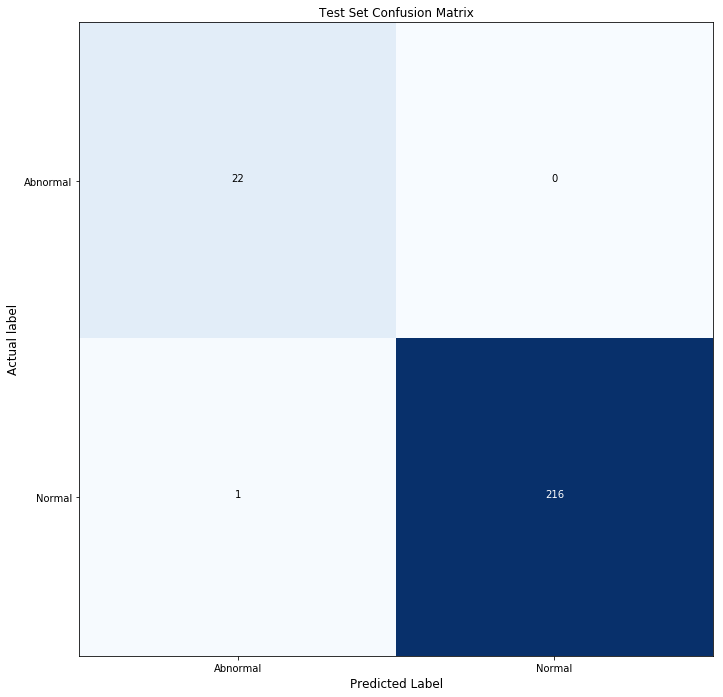

In [43]:
show cnfM:.ml.cfm[dict1[`ytest];pred1]
.ml.displayCM[value cnfM;`Abnormal`Normal;"Test Set Confusion Matrix";()]

### Conclusions

In conclusion it can be seen from multiple runs of the random forest classifiers for different seedings and different splits of the dataset that the use of the feature extraction and significance procedures implemented in this library have improved the ability to predict the normality or otherwise of the wafers produced during the manufacturing process.

The accuracy in the case of using the FRESH library produces consistently more accurate results than the benchmark set as the average value being used for the prediction and significantly better results than the naive case where we would assume that all wafers produced are fit for use further down pipeline.

This gives an insight into the potential for the use of this form of analysis in the manufacturing sector particularly given the large volumes of data consistently recorded in modern manufacturing processes.

It also offers the potential for reductions in redundant labour and manufacturing procedures thus reducing the overall cost of the manufacturing pipeline

---